In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/Copy of A_05_Part_02_Dataset.zip"
with ZipFile(file_name, 'r',) as Zip:
  Zip.extractall()
  print('Done!!')

Done!!


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import glob
import shutil
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix,f1_score
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_dir = 'A_05_Part_02_Dataset' #
c= 0
testFiles =[]
for filename in glob.glob(data_dir + '/Test/' +'/*.*'):
    c+=1
    testFiles.append(filename)
print(c)
for f in testFiles:
    shutil.copy(f, 't/d')

629


In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

test_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

valid_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                       transforms.Normalize([0.252, 0.293, 0.288],
                                                            [0.146, 0.191, 0.193])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)
test_data = datasets.ImageFolder('t', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes: ")
class_names = train_data.classes
print(class_names)


Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
classes = ['covid-19', 'normal', 'pneumonia']
def getAccuracy(givenData, cnn):
    correct = 0
    total = 0
    pr =[]
    tl =[]
    # confusion_matrix = torch.zeros(3,3)
    with torch.no_grad():
        for data in givenData:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels = Encode(labels)
            if cnn == "resnet":
                outputs = resnet18(images)
            elif cnn == "vgg":
                outputs = vgg16(images)
            pred = outputs
            outputs = torch.sigmoid(outputs)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            # _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (outputs == labels).sum().item()
            # print(total, correct, correct/3)
            loss = criterion(pred, labels)

            acc = (100 * (correct/3) / total)

            for i in labels.tolist():
                tl.append(i)
            for j in outputs.tolist():
                pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)
    matrix = confusion_matrix(np.array(tl),np.array(pr))
    print("confusion matrix\n",matrix)
    print("confusion_matrix\n ", multilabel_confusion_matrix(np.array(tl),np.array(pr)))
    print("f1_score ",f1_score(np.array(tl),np.array(pr), average='macro'))
    return acc, loss.item()
def plot(tacc, tloss, vacc, vloss):
    plt.plot(range(len(tloss)), tloss, label = 'Training loss curve')
    plt.legend()
    plt.title('loss curves')
    plt.plot(range(len(vloss)), vloss, label = 'Validation loss curve')
    plt.legend()
    plt.xlabel('Epochs') 
    plt.ylabel('Entropy Loss') 
    plt.show()

    plt.plot(range(len(tacc)), tacc, label = 'Trainging accuracy')
    plt.plot(range(len(vacc)), vacc, label = 'Validation accuracy')
    plt.legend()
    plt.title('Accuracy curves')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.show()
def Encode(label):
    # y_onehot = nn.functional.one_hot(label, num_classes=3)
    # y_onehot = y_onehot.float()

    label = label.tolist()
    for i in range(len(label)):
        if label[i] == 0: #covid-19
            label[i] = [1,0,1]          #['covid-19', 'normal', 'pneumonia']
        elif label[i] == 1: #normal
            label[i] = [0,1,0]
        elif label[i] == 2: #pneumonia
            label[i] = [0,0,1]
    # print(torch.as_tensor(label).cuda())
    # print (label)
    on_hot = torch.as_tensor(label).cuda()
    on_hot = on_hot.float()
    return on_hot
def getAccuracyfocal(givenData, cnn):
    correct = 0
    total = 0
    pr =[]
    tl =[]
    # confusion_matrix = torch.zeros(3,3)
    with torch.no_grad():
        for data in givenData:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            labels = Encode(labels)
            if cnn == "resnet":
                outputs = resnet18(images)
            elif cnn == "vgg":
                outputs = vgg16(images)
            pred = outputs
            outputs = torch.sigmoid(outputs)
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            # _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (outputs == labels).sum().item()
            # print(total, correct, correct/3)
            loss = focal_loss(labels,pred)
            # loss = criterion(outputs, labels)

            acc = (100 * (correct/3) / total)

            for i in labels.tolist():
                tl.append(i)
            for j in outputs.tolist():
                pr.append(j)

    pr = np.argmax(pr, axis=1)
    tl = np.argmax(tl, axis=1)
    matrix = confusion_matrix(np.array(tl),np.array(pr))
    print("confusion matrix\n ",matrix)
    print("confusion_matrix\n ", multilabel_confusion_matrix(np.array(tl),np.array(pr)))
    print("f1_score ",f1_score(np.array(tl),np.array(pr), average='macro'))
    return acc, loss.item()
def focal_loss(label,pred):
    gamma = 2
    a = 0.25
    bceloss = nn.functional.binary_cross_entropy_with_logits(pred, label, reduction='none')
    pt = torch.exp(-bceloss)
    F_loss = a * (1-pt)**gamma * bceloss
    return F_loss.mean()
def test(model, fileName):
    # counter = 0
    l1 =[]
    l2 =[]
    l3 =[]
    with torch.no_grad():
        for data in testloader:
            # counter +=1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            if model == 'vgg':
                outputs = vgg16(images)
            elif model == 'resnet':
                outputs = resnet18(images)
            outputs = torch.sigmoid(outputs)
            outputs[outputs >= 0.5] = 1
            outputs[outputs< 0.5] =0
            for i in outputs.tolist():
                l1.append(i[0])
                l2.append(i[1])
                l3.append(i[2])
    Names =[]
    for i in test_data.imgs:
        a,b,c = i[0].split('/')
        Names.append(c)
    csvdata = pd.DataFrame(list(zip(Names, l1,l3,l2)))
    csvdata.to_csv(fileName, index=False, header = False)
    print('done')

In [0]:
def plotcm(cm, name, label, model, data):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, linewidths= 1,square=True,fmt ='d'); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix '+ ', '+model + ', '+ data + ' data'+ ' label :' +name); 
    ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
    plt.show()

## VGG

In [0]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6]= nn.Linear(4096, 3)
if __name__ == "__main__":
    from torchsummary import summary
    model = vgg16
    model = model.cuda()
    # print(model)
    summary(model, input_size = (3,120,120))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]           1,792
              ReLU-2         [-1, 64, 120, 120]               0
            Conv2d-3         [-1, 64, 120, 120]          36,928
              ReLU-4         [-1, 64, 120, 120]               0
         MaxPool2d-5           [-1, 64, 60, 60]               0
            Conv2d-6          [-1, 128, 60, 60]          73,856
              ReLU-7          [-1, 128, 60, 60]               0
            Conv2d-8          [-1, 128, 60, 60]         147,584
              ReLU-9          [-1, 128, 60, 60]               0
        MaxPool2d-10          [-1, 128, 30, 30]               0
           Conv2d-11          [-1, 256, 30, 30]         295,168
             ReLU-12          [-1, 256, 30, 30]               0
           Conv2d-13          [-1, 256, 30, 30]         590,080
             ReLU-14          [-1, 256

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.201388: : 194it [03:39,  1.13s/it]


Training stats 

confusion matrix
 [[  18  101   81]
 [  85 3684  231]
 [ 121  631 1248]]
confusion_matrix
  [[[5794  206]
  [ 182   18]]

 [[1468  732]
  [ 316 3684]]

 [[3888  312]
  [ 752 1248]]]
f1_score  0.5538348470180264
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  1  19   8]
 [ 11 373  16]
 [ 12  53 135]]
confusion_matrix
  [[[577  23]
  [ 27   1]]

 [[156  72]
  [ 27 373]]

 [[404  24]
  [ 65 135]]]
f1_score  0.5577969705460599

>>tacc, tloss, vacc , vloss
 87.36559139784947 0.3869767189025879 88.11040339702761 0.13683611154556274 
............................



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.317151: : 194it [03:30,  1.09s/it]


Training stats 

confusion matrix
 [[   9   34  157]
 [ 118 3277  605]
 [  31  248 1721]]
confusion_matrix
  [[[5851  149]
  [ 191    9]]

 [[1918  282]
  [ 723 3277]]

 [[3438  762]
  [ 279 1721]]]
f1_score  0.5617048872917255
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  1  11  16]
 [ 22 316  62]
 [  3  17 180]]
confusion_matrix
  [[[575  25]
  [ 27   1]]

 [[200  28]
  [ 84 316]]

 [[350  78]
  [ 20 180]]]
f1_score  0.5575085345005991

>>tacc, tloss, vacc , vloss
 88.07526881720432 0.2372858077287674 86.99575371549894 0.24205268919467926 
............................



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.155229: : 194it [03:29,  1.08s/it]


Training stats 

confusion matrix
 [[   8   51  141]
 [  30 3746  224]
 [  39  436 1525]]
confusion_matrix
  [[[5931   69]
  [ 192    8]]

 [[1713  487]
  [ 254 3746]]

 [[3835  365]
  [ 475 1525]]]
f1_score  0.5839399285459539
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  1  13  14]
 [  6 372  22]
 [  5  27 168]]
confusion_matrix
  [[[589  11]
  [ 27   1]]

 [[188  40]
  [ 28 372]]

 [[392  36]
  [ 32 168]]]
f1_score  0.5993131086507665

>>tacc, tloss, vacc , vloss
 90.83870967741936 0.372538298368454 90.76433121019109 0.17475703358650208 
............................



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.273534: : 194it [03:28,  1.07s/it]


Training stats 

confusion matrix
 [[  15   53  132]
 [  42 3786  172]
 [  42  472 1486]]
confusion_matrix
  [[[5916   84]
  [ 185   15]]

 [[1675  525]
  [ 214 3786]]

 [[3896  304]
  [ 514 1486]]]
f1_score  0.5985283375163618
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  3  13  12]
 [  2 388  10]
 [  4  39 157]]
confusion_matrix
  [[[594   6]
  [ 25   3]]

 [[176  52]
  [ 12 388]]

 [[406  22]
  [ 43 157]]]
f1_score  0.6381559093960149

>>tacc, tloss, vacc , vloss
 91.005376344086 0.20177368819713593 91.66666666666666 0.15689361095428467 
............................



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.220095: : 194it [03:27,  1.07s/it]


Training stats 

confusion matrix
 [[  10   38  152]
 [  31 3746  223]
 [  38  398 1564]]
confusion_matrix
  [[[5931   69]
  [ 190   10]]

 [[1764  436]
  [ 254 3746]]

 [[3825  375]
  [ 436 1564]]]
f1_score  0.5938211029205033
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  1  13  14]
 [  4 380  16]
 [  5  22 173]]
confusion_matrix
  [[[591   9]
  [ 27   1]]

 [[193  35]
  [ 20 380]]

 [[398  30]
  [ 27 173]]]
f1_score  0.6145692368051153

>>tacc, tloss, vacc , vloss
 91.43548387096774 0.21546512842178345 92.19745222929936 0.27545085549354553 
............................



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.204470: : 194it [03:26,  1.07s/it]


Training stats 

confusion matrix
 [[  16   60  124]
 [  27 3859  114]
 [  31  479 1490]]
confusion_matrix
  [[[5942   58]
  [ 184   16]]

 [[1661  539]
  [ 141 3859]]

 [[3962  238]
  [ 510 1490]]]
f1_score  0.6117242948082735
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  3  13  12]
 [  3 388   9]
 [  3  35 162]]
confusion_matrix
  [[[594   6]
  [ 25   3]]

 [[180  48]
  [ 12 388]]

 [[407  21]
  [ 38 162]]]
f1_score  0.6454482766149662

>>tacc, tloss, vacc , vloss
 91.7204301075269 0.2550663352012634 92.35668789808918 0.3221672475337982 
............................



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.047156: : 194it [03:26,  1.06s/it]


Training stats 

confusion matrix
 [[  44   40  116]
 [  28 3797  175]
 [  33  355 1612]]
confusion_matrix
  [[[5939   61]
  [ 156   44]]

 [[1805  395]
  [ 203 3797]]

 [[3909  291]
  [ 388 1612]]]
f1_score  0.680519267098532
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  3  12  13]
 [  1 386  13]
 [  2  24 174]]
confusion_matrix
  [[[597   3]
  [ 25   3]]

 [[192  36]
  [ 14 386]]

 [[402  26]
  [ 26 174]]]
f1_score  0.6618811125423405

>>tacc, tloss, vacc , vloss
 92.56989247311827 0.24258047342300415 92.99363057324841 0.21260663866996765 
............................



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.306672: : 194it [03:27,  1.07s/it]


Training stats 

confusion matrix
 [[  37   44  119]
 [  31 3814  155]
 [  51  384 1565]]
confusion_matrix
  [[[5918   82]
  [ 163   37]]

 [[1772  428]
  [ 186 3814]]

 [[3926  274]
  [ 435 1565]]]
f1_score  0.6575983096208246
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  3  13  12]
 [  6 380  14]
 [  3  22 175]]
confusion_matrix
  [[[591   9]
  [ 25   3]]

 [[193  35]
  [ 20 380]]

 [[402  26]
  [ 25 175]]]
f1_score  0.6517777641785107

>>tacc, tloss, vacc , vloss
 92.38172043010753 0.1458720564842224 92.88747346072188 0.1033133715391159 
............................



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.359615: : 194it [03:25,  1.06s/it]


Training stats 

confusion matrix
 [[  24   42  134]
 [  23 3808  169]
 [  34  350 1616]]
confusion_matrix
  [[[5943   57]
  [ 176   24]]

 [[1808  392]
  [ 192 3808]]

 [[3897  303]
  [ 384 1616]]]
f1_score  0.6414330572533168
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  4  12  12]
 [  5 386   9]
 [  1  25 174]]
confusion_matrix
  [[[594   6]
  [ 24   4]]

 [[191  37]
  [ 14 386]]

 [[407  21]
  [ 26 174]]]
f1_score  0.6765235219182891

>>tacc, tloss, vacc , vloss
 92.6774193548387 0.08298946917057037 93.20594479830149 0.09162235260009766 
............................



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.141411: : 194it [03:27,  1.07s/it]


Training stats 

confusion matrix
 [[  38   38  124]
 [  31 3829  140]
 [  35  361 1604]]
confusion_matrix
  [[[5934   66]
  [ 162   38]]

 [[1801  399]
  [ 171 3829]]

 [[3936  264]
  [ 396 1604]]]
f1_score  0.6700311796327921
validation stats



0it [00:00, ?it/s]

confusion matrix
 [[  3  11  14]
 [  2 386  12]
 [  2  22 176]]
confusion_matrix
  [[[596   4]
  [ 25   3]]

 [[195  33]
  [ 14 386]]

 [[402  26]
  [ 24 176]]]
f1_score  0.6632211348629259

>>tacc, tloss, vacc , vloss
 92.94086021505375 0.08329151570796967 93.52441613588111 0.12958794832229614 
............................



Train Epoch: 10 [4632/6200 (99%)]	Loss: 0.347388: : 194it [03:27,  1.07s/it]


Training stats 

confusion matrix
 [[  65   24  111]
 [  51 3593  356]
 [  28  205 1767]]
confusion_matrix
  [[[5921   79]
  [ 135   65]]

 [[1971  229]
  [ 407 3593]]

 [[3733  467]
  [ 233 1767]]]
f1_score  0.7104231846290748
validation stats

confusion matrix
 [[  4  11  13]
 [  1 373  26]
 [  4  15 181]]
confusion_matrix
  [[[595   5]
  [ 24   4]]

 [[202  26]
  [ 27 373]]

 [[389  39]
  [ 19 181]]]
f1_score  0.6705960206585989

>>tacc, tloss, vacc , vloss
 92.35483870967742 0.26923900842666626 92.78131634819532 0.19893671572208405 
............................

Finished Training


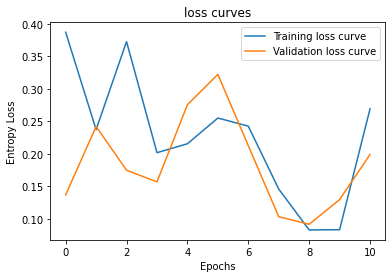

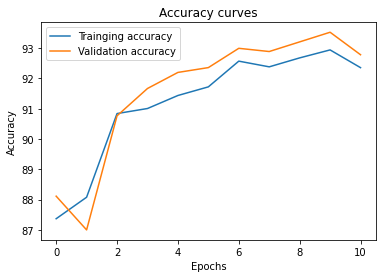

done


In [0]:
#loss function and optimizer
Epochs = 11
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.5)
#Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = vgg16(inputs)               #----> forward pass
        # print(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")

print('Finished Training')
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
test("vgg", "vgg_bce.csv")

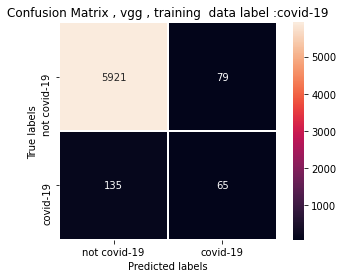

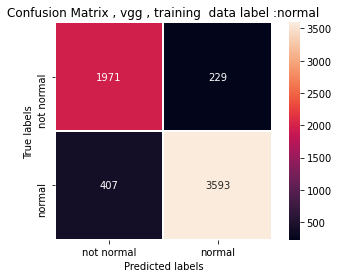

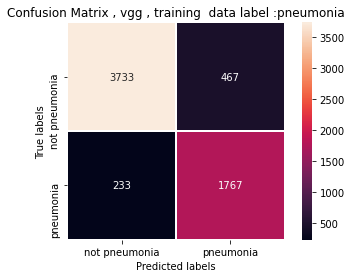

In [5]:
# I am ploting confusion matrix manually, as I have just already got confusion matrix from above code w/o plotting,
#just by using sklearn, and now running again the code is time taking at the last moment so 
#values can be verified from above section results
Training_cm = [[[5921,   79],
  [ 135,   65]],

 [[1971 , 229],
  [ 407 ,3593]],

 [[3733,  467],
  [ 233 ,1767]]]
for i in range(len(classes)):
    plotcm(Training_cm[i], classes[i], [ 'not ' + classes[i],classes[i]], 'vgg ','training ' )


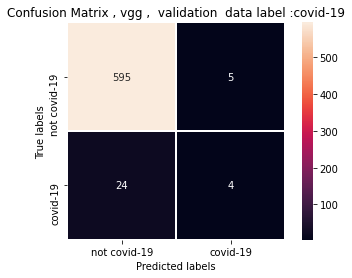

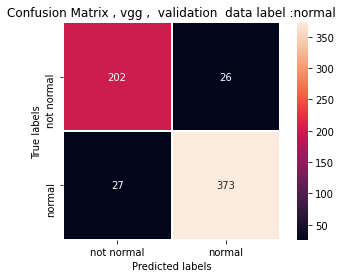

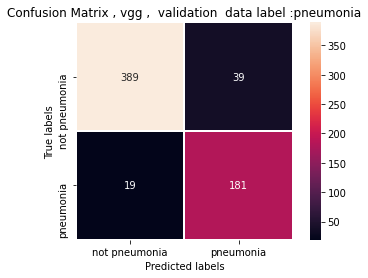

In [6]:
# I am ploting confusion matrix manually, as I have just already got confusion matrix from above code w/o plotting,
#just by using sklearn, and now running again the code is time taking at the last moment so 
#values can be verified from above section results
valid_cm = [[[595,   5],
  [ 24,   4]],
 [[202,  26],
  [ 27, 373]],

 [[389,  39],
  [ 19, 181]]]
for i in range(len(classes)):
    plotcm(valid_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'vgg ',' validation ' )

In [0]:
#loss function and optimizer
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.015, momentum=0.45)
#Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = vgg16(inputs)               #----> forward pass
        # print(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.252640: : 194it [03:26,  1.06s/it]


Training stats 

confusion matrix [[  66   90   44]
 [ 205 3748   47]
 [ 525  595  880]]
f1_score 0.5379373809986195
validation stats



0it [00:00, ?it/s]

confusion matrix [[  5  17   6]
 [ 10 386   4]
 [ 23  42 135]]
f1_score 0.6159111048743157

>>tacc, tloss, vacc , vloss
 86.7741935483871 0.6259535551071167 89.80891719745223 0.6165186762809753 
............................



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.398376: : 194it [03:17,  1.02s/it]


Training stats 

confusion matrix [[  34   24  142]
 [ 312 3467  221]
 [ 142  205 1653]]
f1_score 0.6076773022015308
validation stats



0it [00:00, ?it/s]

confusion matrix [[  4  10  14]
 [ 19 374   7]
 [ 10  14 176]]
f1_score 0.651713591145004

>>tacc, tloss, vacc , vloss
 91.55913978494625 0.627350389957428 93.47133757961784 0.5665186643600464 
............................



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.405795: : 194it [03:12,  1.01it/s]


Training stats 

confusion matrix [[  41   66   93]
 [ 109 3827   64]
 [ 193  444 1363]]
f1_score 0.6145069186885747
validation stats



0it [00:00, ?it/s]

confusion matrix [[  5  13  10]
 [  6 384  10]
 [ 15  22 163]]
f1_score 0.6580296858799906

>>tacc, tloss, vacc , vloss
 91.005376344086 0.5856837034225464 92.46284501061571 0.5998520255088806 
............................



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.106293: : 194it [03:17,  1.02s/it]


Training stats 

confusion matrix [[  28   25  147]
 [ 223 3592  185]
 [ 117  197 1686]]
f1_score 0.6190635078264638
validation stats



0it [00:00, ?it/s]

confusion matrix [[  2   9  17]
 [ 19 358  23]
 [  3  12 185]]
f1_score 0.6222127994082989

>>tacc, tloss, vacc , vloss
 92.7204301075269 0.5962361097335815 92.67515923566879 0.5791814923286438 
............................



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.134493: : 194it [03:10,  1.02it/s]


Training stats 

confusion matrix [[  48   48  104]
 [ 113 3838   49]
 [ 200  364 1436]]
f1_score 0.6339233801307786
validation stats



0it [00:00, ?it/s]

confusion matrix [[  4  12  12]
 [ 12 385   3]
 [  6  17 177]]
f1_score 0.669669056811914

>>tacc, tloss, vacc , vloss
 92.20967741935483 0.6048487424850464 94.26751592356688 0.6561834216117859 
............................



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.372223: : 194it [03:09,  1.02it/s]


Training stats 

confusion matrix [[  45   23  132]
 [ 236 3639  125]
 [ 150  198 1652]]
f1_score 0.6379379673785744
validation stats



0it [00:00, ?it/s]

confusion matrix [[  6  10  12]
 [ 23 367  10]
 [  5  10 185]]
f1_score 0.6784316501904729

>>tacc, tloss, vacc , vloss
 93.12365591397851 0.627350389957428 94.16135881104034 0.5831853747367859 
............................



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.191265: : 194it [03:13,  1.00it/s]


Training stats 

confusion matrix [[  91   23   86]
 [ 167 3690  143]
 [ 159  225 1616]]
f1_score 0.6884176919626174
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 16   8   4]
 [ 13 382   5]
 [  8  15 177]]
f1_score 0.7861581536283047

>>tacc, tloss, vacc , vloss
 93.28494623655915 0.6048487424850464 94.95753715498938 0.6228500604629517 
............................



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.160027: : 194it [03:08,  1.03it/s]


Training stats 

confusion matrix [[  59   46   95]
 [  96 3850   54]
 [ 155  347 1498]]
f1_score 0.6623318649894029
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 10  13   5]
 [  4 393   3]
 [  9  21 170]]
f1_score 0.7473503262203264

>>tacc, tloss, vacc , vloss
 92.70430107526883 0.6134614944458008 94.10828025477707 0.5768539309501648 
............................



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.289583: : 194it [03:10,  1.02it/s]


Training stats 

confusion matrix [[  80   30   90]
 [ 157 3767   76]
 [ 183  252 1565]]
f1_score 0.6776661976728368
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 13  10   5]
 [  7 391   2]
 [  5  19 176]]
f1_score 0.7877615421801787

>>tacc, tloss, vacc , vloss
 93.38709677419355 0.594296395778656 94.95753715498938 0.5831853747367859 
............................



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.112625: : 194it [03:11,  1.01it/s]


Training stats 

confusion matrix [[ 103   39   58]
 [  78 3870   52]
 [ 147  297 1556]]
f1_score 0.7274151378951448
validation stats

confusion matrix [[ 14  10   4]
 [  4 395   1]
 [  8  19 173]]
f1_score 0.7975334326467013

>>tacc, tloss, vacc , vloss
 93.83333333333334 0.5856837034225464 95.43524416135881 0.5665186643600464 
............................

Finished Training


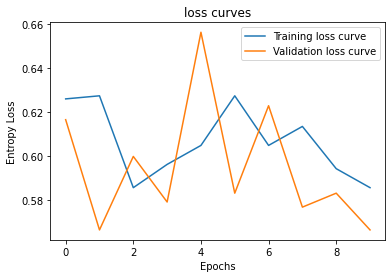

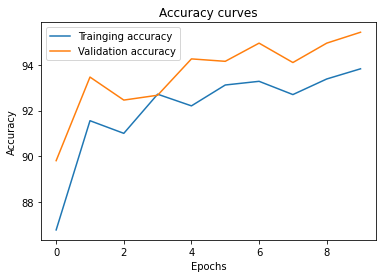

In [0]:
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

In [0]:
test("vgg", "vgg_bce.csv")
vgg_bce=pd.read_csv('vgg_bce.csv')
vgg_bce.head()

done


,0.png,0.0,0.0.1,1.0
0,1.png,0.0,0.0,1.0
1,10.png,0.0,0.0,1.0
2,100.png,0.0,1.0,0.0
3,101.png,0.0,0.0,1.0
4,102.png,0.0,0.0,1.0


## resnet

In [0]:
resnet18 = models.resnet18(pretrained=True)
new_fc_resnet = [nn.Linear(512, 3) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
if __name__ == "__main__":
    from torchsummary import summary
    model = resnet18
    model = model.cuda()
    # print(model)
    summary(model, input_size = (3,120,120))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]           9,408
       BatchNorm2d-2           [-1, 64, 60, 60]             128
              ReLU-3           [-1, 64, 60, 60]               0
         MaxPool2d-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,864
       BatchNorm2d-6           [-1, 64, 30, 30]             128
              ReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]          36,864
       BatchNorm2d-9           [-1, 64, 30, 30]             128
             ReLU-10           [-1, 64, 30, 30]               0
       BasicBlock-11           [-1, 64, 30, 30]               0
           Conv2d-12           [-1, 64, 30, 30]          36,864
      BatchNorm2d-13           [-1, 64, 30, 30]             128
             ReLU-14           [-1, 64


0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.263332: : 0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.263332: : 1it [00:00,  1.33it/s]
Train Epoch: 0 [32/6200 (1%)]	Loss: 0.278408: : 1it [00:01,  1.33it/s]
Train Epoch: 0 [32/6200 (1%)]	Loss: 0.278408: : 2it [00:01,  1.34it/s]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.189080: : 2it [00:02,  1.34it/s]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.189080: : 3it [00:02,  1.33it/s]
Train Epoch: 0 [96/6200 (2%)]	Loss: 0.220242: : 3it [00:03,  1.33it/s]
Train Epoch: 0 [96/6200 (2%)]	Loss: 0.220242: : 4it [00:03,  1.33it/s]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.114512: : 4it [00:03,  1.33it/s]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.114512: : 5it [00:03,  1.33it/s]
Train Epoch: 0 [160/6200 (3%)]	Loss: 0.344117: : 5it [00:04,  1.33it/s]
Train Epoch: 0 [160/6200 (3%)]	Loss: 0.344117: : 6it [00:04,  1.34it/s]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.196633: : 6it [00:05,  1.34it/s]
Train Epoch: 0 [192/6200 (3%)]	Loss: 0.196633: : 7it [00:0

Training stats 

confusion matrix
 [[   4   44  152]
 [  35 3660  305]
 [  20  298 1682]]
confusion_matrix
  [[[5945   55]
  [ 196    4]]

 [[1858  342]
  [ 340 3660]]

 [[3743  457]
  [ 318 1682]]]
f1_score  0.5861386808597457
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[  1  12  15]
 [  2 375  23]
 [  2  19 179]]
confusion_matrix
  [[[596   4]
  [ 27   1]]

 [[197  31]
  [ 25 375]]

 [[390  38]
  [ 21 179]]]
f1_score  0.6165467806219721

>>tacc, tloss, vacc , vloss
 91.66666666666666 0.10588648915290833 92.40976645435245 0.28171178698539734 
............................




Train Epoch: 1 [0/6200 (0%)]	Loss: 0.300613: : 0it [00:00, ?it/s]
Train Epoch: 1 [0/6200 (0%)]	Loss: 0.300613: : 1it [00:00,  1.39it/s]
Train Epoch: 1 [32/6200 (1%)]	Loss: 0.161520: : 1it [00:01,  1.39it/s]
Train Epoch: 1 [32/6200 (1%)]	Loss: 0.161520: : 2it [00:01,  1.38it/s]
Train Epoch: 1 [64/6200 (1%)]	Loss: 0.101297: : 2it [00:02,  1.38it/s]
Train Epoch: 1 [64/6200 (1%)]	Loss: 0.101297: : 3it [00:02,  1.38it/s]
Train Epoch: 1 [96/6200 (2%)]	Loss: 0.142025: : 3it [00:03,  1.38it/s]
Train Epoch: 1 [96/6200 (2%)]	Loss: 0.142025: : 4it [00:03,  1.21it/s]
Train Epoch: 1 [128/6200 (2%)]	Loss: 0.299881: : 4it [00:04,  1.21it/s]
Train Epoch: 1 [128/6200 (2%)]	Loss: 0.299881: : 5it [00:04,  1.22it/s]
Train Epoch: 1 [160/6200 (3%)]	Loss: 0.202754: : 5it [00:04,  1.22it/s]
Train Epoch: 1 [160/6200 (3%)]	Loss: 0.202754: : 6it [00:04,  1.22it/s]
Train Epoch: 1 [192/6200 (3%)]	Loss: 0.208145: : 6it [00:05,  1.22it/s]
Train Epoch: 1 [192/6200 (3%)]	Loss: 0.208145: : 7it [00:05,  1.26it/s]
Train

Training stats 

confusion matrix
 [[  27   42  131]
 [  23 3766  211]
 [  36  397 1567]]
confusion_matrix
  [[[5941   59]
  [ 173   27]]

 [[1761  439]
  [ 234 3766]]

 [[3858  342]
  [ 433 1567]]]
f1_score  0.6361758691794428
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[  0  12  16]
 [  2 381  17]
 [  2  24 174]]
confusion_matrix
  [[[596   4]
  [ 28   0]]

 [[192  36]
  [ 19 381]]

 [[395  33]
  [ 26 174]]]
f1_score  0.5959057978641822

>>tacc, tloss, vacc , vloss
 91.7741935483871 0.14171689748764038 92.72823779193206 0.2334999144077301 
............................




Train Epoch: 2 [0/6200 (0%)]	Loss: 0.253880: : 0it [00:00, ?it/s]
Train Epoch: 2 [0/6200 (0%)]	Loss: 0.253880: : 1it [00:00,  1.41it/s]
Train Epoch: 2 [32/6200 (1%)]	Loss: 0.144798: : 1it [00:01,  1.41it/s]
Train Epoch: 2 [32/6200 (1%)]	Loss: 0.144798: : 2it [00:01,  1.39it/s]
Train Epoch: 2 [64/6200 (1%)]	Loss: 0.212786: : 2it [00:02,  1.39it/s]
Train Epoch: 2 [64/6200 (1%)]	Loss: 0.212786: : 3it [00:02,  1.37it/s]
Train Epoch: 2 [96/6200 (2%)]	Loss: 0.209808: : 3it [00:02,  1.37it/s]
Train Epoch: 2 [96/6200 (2%)]	Loss: 0.209808: : 4it [00:02,  1.38it/s]
Train Epoch: 2 [128/6200 (2%)]	Loss: 0.135164: : 4it [00:03,  1.38it/s]
Train Epoch: 2 [128/6200 (2%)]	Loss: 0.135164: : 5it [00:03,  1.37it/s]
Train Epoch: 2 [160/6200 (3%)]	Loss: 0.189801: : 5it [00:04,  1.37it/s]
Train Epoch: 2 [160/6200 (3%)]	Loss: 0.189801: : 6it [00:04,  1.38it/s]
Train Epoch: 2 [192/6200 (3%)]	Loss: 0.135620: : 6it [00:05,  1.38it/s]
Train Epoch: 2 [192/6200 (3%)]	Loss: 0.135620: : 7it [00:05,  1.39it/s]
Train

Training stats 

confusion matrix
 [[  64   40   96]
 [  18 3799  183]
 [  35  356 1609]]
confusion_matrix
  [[[5947   53]
  [ 136   64]]

 [[1804  396]
  [ 201 3799]]

 [[3921  279]
  [ 391 1609]]]
f1_score  0.7195370292418927
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[  9  10   9]
 [  3 378  19]
 [  3  17 180]]
confusion_matrix
  [[[594   6]
  [ 19   9]]

 [[201  27]
  [ 22 378]]

 [[400  28]
  [ 20 180]]]
f1_score  0.7466960090406234

>>tacc, tloss, vacc , vloss
 92.73655913978496 0.17514009773731232 93.47133757961784 0.19203345477581024 
............................




Train Epoch: 3 [0/6200 (0%)]	Loss: 0.165573: : 0it [00:00, ?it/s]
Train Epoch: 3 [0/6200 (0%)]	Loss: 0.165573: : 1it [00:00,  1.40it/s]
Train Epoch: 3 [32/6200 (1%)]	Loss: 0.311343: : 1it [00:01,  1.40it/s]
Train Epoch: 3 [32/6200 (1%)]	Loss: 0.311343: : 2it [00:01,  1.39it/s]
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.433772: : 2it [00:02,  1.39it/s]
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.433772: : 3it [00:02,  1.21it/s]
Train Epoch: 3 [96/6200 (2%)]	Loss: 0.096672: : 3it [00:03,  1.21it/s]
Train Epoch: 3 [96/6200 (2%)]	Loss: 0.096672: : 4it [00:03,  1.26it/s]
Train Epoch: 3 [128/6200 (2%)]	Loss: 0.173208: : 4it [00:04,  1.26it/s]
Train Epoch: 3 [128/6200 (2%)]	Loss: 0.173208: : 5it [00:04,  1.12it/s]
Train Epoch: 3 [160/6200 (3%)]	Loss: 0.268643: : 5it [00:05,  1.12it/s]
Train Epoch: 3 [160/6200 (3%)]	Loss: 0.268643: : 6it [00:05,  1.19it/s]
Train Epoch: 3 [192/6200 (3%)]	Loss: 0.106721: : 6it [00:05,  1.19it/s]
Train Epoch: 3 [192/6200 (3%)]	Loss: 0.106721: : 7it [00:05,  1.24it/s]
Train

Training stats 

confusion matrix
 [[  68   26  106]
 [  36 3673  291]
 [  19  249 1732]]
confusion_matrix
  [[[5945   55]
  [ 132   68]]

 [[1925  275]
  [ 327 3673]]

 [[3803  397]
  [ 268 1732]]]
f1_score  0.7280847869053785
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[  8   7  13]
 [  1 371  28]
 [  1  13 186]]
confusion_matrix
  [[[598   2]
  [ 20   8]]

 [[208  20]
  [ 29 371]]

 [[387  41]
  [ 14 186]]]
f1_score  0.7434333694383936

>>tacc, tloss, vacc , vloss
 92.76344086021504 0.18741796910762787 93.57749469214437 0.21573080122470856 
............................




Train Epoch: 4 [0/6200 (0%)]	Loss: 0.238833: : 0it [00:01, ?it/s]
Train Epoch: 4 [0/6200 (0%)]	Loss: 0.238833: : 1it [00:01,  1.13s/it]
Train Epoch: 4 [32/6200 (1%)]	Loss: 0.267888: : 1it [00:01,  1.13s/it]
Train Epoch: 4 [32/6200 (1%)]	Loss: 0.267888: : 2it [00:01,  1.01s/it]
Train Epoch: 4 [64/6200 (1%)]	Loss: 0.177057: : 2it [00:02,  1.01s/it]
Train Epoch: 4 [64/6200 (1%)]	Loss: 0.177057: : 3it [00:02,  1.08it/s]
Train Epoch: 4 [96/6200 (2%)]	Loss: 0.259672: : 3it [00:03,  1.08it/s]
Train Epoch: 4 [96/6200 (2%)]	Loss: 0.259672: : 4it [00:03,  1.16it/s]
Train Epoch: 4 [128/6200 (2%)]	Loss: 0.170691: : 4it [00:04,  1.16it/s]
Train Epoch: 4 [128/6200 (2%)]	Loss: 0.170691: : 5it [00:04,  1.21it/s]
Train Epoch: 4 [160/6200 (3%)]	Loss: 0.141080: : 5it [00:04,  1.21it/s]
Train Epoch: 4 [160/6200 (3%)]	Loss: 0.141080: : 6it [00:04,  1.18it/s]
Train Epoch: 4 [192/6200 (3%)]	Loss: 0.407657: : 6it [00:05,  1.18it/s]
Train Epoch: 4 [192/6200 (3%)]	Loss: 0.407657: : 7it [00:05,  1.21it/s]
Train

Training stats 

confusion matrix
 [[  89   23   88]
 [  20 3651  329]
 [  30  236 1734]]
confusion_matrix
  [[[5950   50]
  [ 111   89]]

 [[1941  259]
  [ 349 3651]]

 [[3783  417]
  [ 266 1734]]]
f1_score  0.7612234509128956
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 14   7   7]
 [  0 374  26]
 [  3  13 184]]
confusion_matrix
  [[[597   3]
  [ 14  14]]

 [[208  20]
  [ 26 374]]

 [[395  33]
  [ 16 184]]]
f1_score  0.8155939060674213

>>tacc, tloss, vacc , vloss
 92.73118279569891 0.13842596113681793 94.10828025477707 0.28050506114959717 
............................




Train Epoch: 5 [0/6200 (0%)]	Loss: 0.174589: : 0it [00:00, ?it/s]
Train Epoch: 5 [0/6200 (0%)]	Loss: 0.174589: : 1it [00:00,  1.44it/s]
Train Epoch: 5 [32/6200 (1%)]	Loss: 0.104098: : 1it [00:01,  1.44it/s]
Train Epoch: 5 [32/6200 (1%)]	Loss: 0.104098: : 2it [00:01,  1.44it/s]
Train Epoch: 5 [64/6200 (1%)]	Loss: 0.193502: : 2it [00:02,  1.44it/s]
Train Epoch: 5 [64/6200 (1%)]	Loss: 0.193502: : 3it [00:02,  1.37it/s]
Train Epoch: 5 [96/6200 (2%)]	Loss: 0.186324: : 3it [00:03,  1.37it/s]
Train Epoch: 5 [96/6200 (2%)]	Loss: 0.186324: : 4it [00:03,  1.28it/s]
Train Epoch: 5 [128/6200 (2%)]	Loss: 0.259209: : 4it [00:03,  1.28it/s]
Train Epoch: 5 [128/6200 (2%)]	Loss: 0.259209: : 5it [00:03,  1.32it/s]
Train Epoch: 5 [160/6200 (3%)]	Loss: 0.186372: : 5it [00:04,  1.32it/s]
Train Epoch: 5 [160/6200 (3%)]	Loss: 0.186372: : 6it [00:04,  1.30it/s]
Train Epoch: 5 [192/6200 (3%)]	Loss: 0.116737: : 6it [00:05,  1.30it/s]
Train Epoch: 5 [192/6200 (3%)]	Loss: 0.116737: : 7it [00:05,  1.34it/s]
Train

Training stats 

confusion matrix
 [[  73   37   90]
 [  18 3860  122]
 [  23  410 1567]]
confusion_matrix
  [[[5959   41]
  [ 127   73]]

 [[1753  447]
  [ 140 3860]]

 [[3988  212]
  [ 433 1567]]]
f1_score  0.7412082609190526
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 13  10   5]
 [  0 391   9]
 [  1  24 175]]
confusion_matrix
  [[[599   1]
  [ 15  13]]

 [[194  34]
  [  9 391]]

 [[414  14]
  [ 25 175]]]
f1_score  0.8222231125058889

>>tacc, tloss, vacc , vloss
 92.95698924731181 0.3073694407939911 94.4267515923567 0.06189064681529999 
............................




Train Epoch: 6 [0/6200 (0%)]	Loss: 0.086548: : 0it [00:00, ?it/s]
Train Epoch: 6 [0/6200 (0%)]	Loss: 0.086548: : 1it [00:00,  1.41it/s]
Train Epoch: 6 [32/6200 (1%)]	Loss: 0.236139: : 1it [00:01,  1.41it/s]
Train Epoch: 6 [32/6200 (1%)]	Loss: 0.236139: : 2it [00:01,  1.31it/s]
Train Epoch: 6 [64/6200 (1%)]	Loss: 0.117132: : 2it [00:02,  1.31it/s]
Train Epoch: 6 [64/6200 (1%)]	Loss: 0.117132: : 3it [00:02,  1.34it/s]
Train Epoch: 6 [96/6200 (2%)]	Loss: 0.264940: : 3it [00:02,  1.34it/s]
Train Epoch: 6 [96/6200 (2%)]	Loss: 0.264940: : 4it [00:03,  1.36it/s]
Train Epoch: 6 [128/6200 (2%)]	Loss: 0.180603: : 4it [00:03,  1.36it/s]
Train Epoch: 6 [128/6200 (2%)]	Loss: 0.180603: : 5it [00:03,  1.31it/s]
Train Epoch: 6 [160/6200 (3%)]	Loss: 0.247255: : 5it [00:04,  1.31it/s]
Train Epoch: 6 [160/6200 (3%)]	Loss: 0.247255: : 6it [00:04,  1.35it/s]
Train Epoch: 6 [192/6200 (3%)]	Loss: 0.087209: : 6it [00:05,  1.35it/s]
Train Epoch: 6 [192/6200 (3%)]	Loss: 0.087209: : 7it [00:05,  1.36it/s]
Train

Training stats 

confusion matrix
 [[  82   24   94]
 [  26 3738  236]
 [   9  242 1749]]
confusion_matrix
  [[[5965   35]
  [ 118   82]]

 [[1934  266]
  [ 262 3738]]

 [[3870  330]
  [ 251 1749]]]
f1_score  0.7696487564848843
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 14   9   5]
 [  0 381  19]
 [  0  17 183]]
confusion_matrix
  [[[600   0]
  [ 14  14]]

 [[202  26]
  [ 19 381]]

 [[404  24]
  [ 17 183]]]
f1_score  0.8367224947150599

>>tacc, tloss, vacc , vloss
 93.75806451612904 0.327972412109375 94.37367303609341 0.07711095362901688 
............................




Train Epoch: 7 [0/6200 (0%)]	Loss: 0.374245: : 0it [00:00, ?it/s]
Train Epoch: 7 [0/6200 (0%)]	Loss: 0.374245: : 1it [00:00,  1.28it/s]
Train Epoch: 7 [32/6200 (1%)]	Loss: 0.270390: : 1it [00:01,  1.28it/s]
Train Epoch: 7 [32/6200 (1%)]	Loss: 0.270390: : 2it [00:01,  1.32it/s]
Train Epoch: 7 [64/6200 (1%)]	Loss: 0.077004: : 2it [00:02,  1.32it/s]
Train Epoch: 7 [64/6200 (1%)]	Loss: 0.077004: : 3it [00:02,  1.35it/s]
Train Epoch: 7 [96/6200 (2%)]	Loss: 0.219036: : 3it [00:02,  1.35it/s]
Train Epoch: 7 [96/6200 (2%)]	Loss: 0.219036: : 4it [00:02,  1.37it/s]
Train Epoch: 7 [128/6200 (2%)]	Loss: 0.071651: : 4it [00:03,  1.37it/s]
Train Epoch: 7 [128/6200 (2%)]	Loss: 0.071651: : 5it [00:03,  1.39it/s]
Train Epoch: 7 [160/6200 (3%)]	Loss: 0.091299: : 5it [00:04,  1.39it/s]
Train Epoch: 7 [160/6200 (3%)]	Loss: 0.091299: : 6it [00:04,  1.38it/s]
Train Epoch: 7 [192/6200 (3%)]	Loss: 0.134862: : 6it [00:05,  1.38it/s]
Train Epoch: 7 [192/6200 (3%)]	Loss: 0.134862: : 7it [00:05,  1.36it/s]
Train

Training stats 

confusion matrix
 [[  88   37   75]
 [  13 3769  218]
 [  16  265 1719]]
confusion_matrix
  [[[5971   29]
  [ 112   88]]

 [[1898  302]
  [ 231 3769]]

 [[3907  293]
  [ 281 1719]]]
f1_score  0.7820317849869728
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 17   7   4]
 [  0 377  23]
 [  4  19 177]]
confusion_matrix
  [[[596   4]
  [ 11  17]]

 [[202  26]
  [ 23 377]]

 [[401  27]
  [ 23 177]]]
f1_score  0.8363646680575242

>>tacc, tloss, vacc , vloss
 93.56451612903226 0.17316074669361115 93.84288747346072 0.04466870427131653 
............................




Train Epoch: 8 [0/6200 (0%)]	Loss: 0.109549: : 0it [00:00, ?it/s]
Train Epoch: 8 [0/6200 (0%)]	Loss: 0.109549: : 1it [00:00,  1.41it/s]
Train Epoch: 8 [32/6200 (1%)]	Loss: 0.113917: : 1it [00:01,  1.41it/s]
Train Epoch: 8 [32/6200 (1%)]	Loss: 0.113917: : 2it [00:01,  1.41it/s]
Train Epoch: 8 [64/6200 (1%)]	Loss: 0.228081: : 2it [00:02,  1.41it/s]
Train Epoch: 8 [64/6200 (1%)]	Loss: 0.228081: : 3it [00:02,  1.41it/s]
Train Epoch: 8 [96/6200 (2%)]	Loss: 0.239497: : 3it [00:02,  1.41it/s]
Train Epoch: 8 [96/6200 (2%)]	Loss: 0.239497: : 4it [00:02,  1.37it/s]
Train Epoch: 8 [128/6200 (2%)]	Loss: 0.187406: : 4it [00:03,  1.37it/s]
Train Epoch: 8 [128/6200 (2%)]	Loss: 0.187406: : 5it [00:03,  1.37it/s]
Train Epoch: 8 [160/6200 (3%)]	Loss: 0.211760: : 5it [00:04,  1.37it/s]
Train Epoch: 8 [160/6200 (3%)]	Loss: 0.211760: : 6it [00:04,  1.38it/s]
Train Epoch: 8 [192/6200 (3%)]	Loss: 0.176711: : 6it [00:05,  1.38it/s]
Train Epoch: 8 [192/6200 (3%)]	Loss: 0.176711: : 7it [00:05,  1.40it/s]
Train

Training stats 

confusion matrix
 [[ 107   17   76]
 [  12 3811  177]
 [  20  276 1704]]
confusion_matrix
  [[[5968   32]
  [  93  107]]

 [[1907  293]
  [ 189 3811]]

 [[3947  253]
  [ 296 1704]]]
f1_score  0.8110167213958278
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 19   7   2]
 [  1 385  14]
 [  2  13 185]]
confusion_matrix
  [[[597   3]
  [  9  19]]

 [[208  20]
  [ 15 385]]

 [[412  16]
  [ 15 185]]]
f1_score  0.8797383353211176

>>tacc, tloss, vacc , vloss
 94.25806451612904 0.09958627820014954 95.80679405520169 0.03502196818590164 
............................




Train Epoch: 9 [0/6200 (0%)]	Loss: 0.146164: : 0it [00:00, ?it/s]
Train Epoch: 9 [0/6200 (0%)]	Loss: 0.146164: : 1it [00:00,  1.11it/s]
Train Epoch: 9 [32/6200 (1%)]	Loss: 0.225493: : 1it [00:01,  1.11it/s]
Train Epoch: 9 [32/6200 (1%)]	Loss: 0.225493: : 2it [00:01,  1.18it/s]
Train Epoch: 9 [64/6200 (1%)]	Loss: 0.137395: : 2it [00:02,  1.18it/s]
Train Epoch: 9 [64/6200 (1%)]	Loss: 0.137395: : 3it [00:02,  1.25it/s]
Train Epoch: 9 [96/6200 (2%)]	Loss: 0.050484: : 3it [00:03,  1.25it/s]
Train Epoch: 9 [96/6200 (2%)]	Loss: 0.050484: : 4it [00:03,  1.24it/s]
Train Epoch: 9 [128/6200 (2%)]	Loss: 0.076157: : 4it [00:03,  1.24it/s]
Train Epoch: 9 [128/6200 (2%)]	Loss: 0.076157: : 5it [00:03,  1.28it/s]
Train Epoch: 9 [160/6200 (3%)]	Loss: 0.165362: : 5it [00:04,  1.28it/s]
Train Epoch: 9 [160/6200 (3%)]	Loss: 0.165362: : 6it [00:04,  1.32it/s]
Train Epoch: 9 [192/6200 (3%)]	Loss: 0.215556: : 6it [00:05,  1.32it/s]
Train Epoch: 9 [192/6200 (3%)]	Loss: 0.215556: : 7it [00:05,  1.34it/s]
Train

Training stats 

confusion matrix
 [[ 111   27   62]
 [  16 3765  219]
 [  24  276 1700]]
confusion_matrix
  [[[5960   40]
  [  89  111]]

 [[1897  303]
  [ 235 3765]]

 [[3919  281]
  [ 300 1700]]]
f1_score  0.8066174030912712
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 19   5   4]
 [  2 378  20]
 [  2  15 183]]
confusion_matrix
  [[[596   4]
  [  9  19]]

 [[208  20]
  [ 22 378]]

 [[404  24]
  [ 17 183]]]
f1_score  0.8639097865104058

>>tacc, tloss, vacc , vloss
 93.63978494623657 0.21411821246147156 94.85138004246284 0.08192038536071777 
............................




Train Epoch: 10 [0/6200 (0%)]	Loss: 0.230999: : 0it [00:00, ?it/s]
Train Epoch: 10 [0/6200 (0%)]	Loss: 0.230999: : 1it [00:00,  1.24it/s]
Train Epoch: 10 [32/6200 (1%)]	Loss: 0.141280: : 1it [00:01,  1.24it/s]
Train Epoch: 10 [32/6200 (1%)]	Loss: 0.141280: : 2it [00:01,  1.29it/s]
Train Epoch: 10 [64/6200 (1%)]	Loss: 0.113828: : 2it [00:02,  1.29it/s]
Train Epoch: 10 [64/6200 (1%)]	Loss: 0.113828: : 3it [00:02,  1.33it/s]
Train Epoch: 10 [96/6200 (2%)]	Loss: 0.093424: : 3it [00:03,  1.33it/s]
Train Epoch: 10 [96/6200 (2%)]	Loss: 0.093424: : 4it [00:03,  1.31it/s]
Train Epoch: 10 [128/6200 (2%)]	Loss: 0.143443: : 4it [00:04,  1.31it/s]
Train Epoch: 10 [128/6200 (2%)]	Loss: 0.143443: : 5it [00:04,  1.18it/s]
Train Epoch: 10 [160/6200 (3%)]	Loss: 0.116979: : 5it [00:04,  1.18it/s]
Train Epoch: 10 [160/6200 (3%)]	Loss: 0.116979: : 6it [00:04,  1.25it/s]
Train Epoch: 10 [192/6200 (3%)]	Loss: 0.126091: : 6it [00:05,  1.25it/s]
Train Epoch: 10 [192/6200 (3%)]	Loss: 0.126091: : 7it [00:05,  1

Training stats 

confusion matrix
 [[ 116   28   56]
 [  13 3876  111]
 [  24  330 1646]]
confusion_matrix
  [[[5963   37]
  [  84  116]]

 [[1842  358]
  [ 124 3876]]

 [[4033  167]
  [ 354 1646]]]
f1_score  0.8206827359406255
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 20   7   1]
 [  2 389   9]
 [  5  17 178]]
confusion_matrix
  [[[593   7]
  [  8  20]]

 [[204  24]
  [ 11 389]]

 [[418  10]
  [ 22 178]]]
f1_score  0.8672493566547662

>>tacc, tloss, vacc , vloss
 94.25268817204302 0.12318229675292969 95.54140127388536 0.033619798719882965 
............................




Train Epoch: 11 [0/6200 (0%)]	Loss: 0.249200: : 0it [00:00, ?it/s]
Train Epoch: 11 [0/6200 (0%)]	Loss: 0.249200: : 1it [00:00,  1.40it/s]
Train Epoch: 11 [32/6200 (1%)]	Loss: 0.074534: : 1it [00:01,  1.40it/s]
Train Epoch: 11 [32/6200 (1%)]	Loss: 0.074534: : 2it [00:01,  1.39it/s]
Train Epoch: 11 [64/6200 (1%)]	Loss: 0.143306: : 2it [00:02,  1.39it/s]
Train Epoch: 11 [64/6200 (1%)]	Loss: 0.143306: : 3it [00:02,  1.37it/s]
Train Epoch: 11 [96/6200 (2%)]	Loss: 0.149340: : 3it [00:02,  1.37it/s]
Train Epoch: 11 [96/6200 (2%)]	Loss: 0.149340: : 4it [00:02,  1.39it/s]
Train Epoch: 11 [128/6200 (2%)]	Loss: 0.157083: : 4it [00:03,  1.39it/s]
Train Epoch: 11 [128/6200 (2%)]	Loss: 0.157083: : 5it [00:03,  1.37it/s]
Train Epoch: 11 [160/6200 (3%)]	Loss: 0.112270: : 5it [00:04,  1.37it/s]
Train Epoch: 11 [160/6200 (3%)]	Loss: 0.112270: : 6it [00:04,  1.26it/s]
Train Epoch: 11 [192/6200 (3%)]	Loss: 0.218152: : 6it [00:05,  1.26it/s]
Train Epoch: 11 [192/6200 (3%)]	Loss: 0.218152: : 7it [00:05,  1

Training stats 

confusion matrix
 [[ 101   25   74]
 [  10 3803  187]
 [  11  283 1706]]
confusion_matrix
  [[[5979   21]
  [  99  101]]

 [[1892  308]
  [ 197 3803]]

 [[3939  261]
  [ 294 1706]]]
f1_score  0.8083879519838524
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 20   6   2]
 [  2 380  18]
 [  3  15 182]]
confusion_matrix
  [[[595   5]
  [  8  20]]

 [[207  21]
  [ 20 380]]

 [[408  20]
  [ 18 182]]]
f1_score  0.8696678668232812

>>tacc, tloss, vacc , vloss
 94.03763440860214 0.15554912388324738 94.95753715498938 0.1311829835176468 
............................




Train Epoch: 12 [0/6200 (0%)]	Loss: 0.158994: : 0it [00:00, ?it/s]
Train Epoch: 12 [0/6200 (0%)]	Loss: 0.158994: : 1it [00:00,  1.42it/s]
Train Epoch: 12 [32/6200 (1%)]	Loss: 0.214535: : 1it [00:01,  1.42it/s]
Train Epoch: 12 [32/6200 (1%)]	Loss: 0.214535: : 2it [00:01,  1.42it/s]
Train Epoch: 12 [64/6200 (1%)]	Loss: 0.113146: : 2it [00:02,  1.42it/s]
Train Epoch: 12 [64/6200 (1%)]	Loss: 0.113146: : 3it [00:02,  1.41it/s]
Train Epoch: 12 [96/6200 (2%)]	Loss: 0.151480: : 3it [00:02,  1.41it/s]
Train Epoch: 12 [96/6200 (2%)]	Loss: 0.151480: : 4it [00:02,  1.42it/s]
Train Epoch: 12 [128/6200 (2%)]	Loss: 0.098544: : 4it [00:03,  1.42it/s]
Train Epoch: 12 [128/6200 (2%)]	Loss: 0.098544: : 5it [00:03,  1.42it/s]
Train Epoch: 12 [160/6200 (3%)]	Loss: 0.157741: : 5it [00:04,  1.42it/s]
Train Epoch: 12 [160/6200 (3%)]	Loss: 0.157741: : 6it [00:04,  1.37it/s]
Train Epoch: 12 [192/6200 (3%)]	Loss: 0.066123: : 6it [00:05,  1.37it/s]
Train Epoch: 12 [192/6200 (3%)]	Loss: 0.066123: : 7it [00:05,  1

Training stats 

confusion matrix
 [[ 113   31   56]
 [  14 3854  132]
 [  23  267 1710]]
confusion_matrix
  [[[5963   37]
  [  87  113]]

 [[1902  298]
  [ 146 3854]]

 [[4012  188]
  [ 290 1710]]]
f1_score  0.8228740451972517
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 14   7   7]
 [  0 385  15]
 [  2  19 179]]
confusion_matrix
  [[[598   2]
  [ 14  14]]

 [[202  26]
  [ 15 385]]

 [[406  22]
  [ 21 179]]]
f1_score  0.8261922818779751

>>tacc, tloss, vacc , vloss
 94.6021505376344 0.0635695531964302 94.85138004246284 0.15733762085437775 
............................




Train Epoch: 13 [0/6200 (0%)]	Loss: 0.200953: : 0it [00:00, ?it/s]
Train Epoch: 13 [0/6200 (0%)]	Loss: 0.200953: : 1it [00:00,  1.42it/s]
Train Epoch: 13 [32/6200 (1%)]	Loss: 0.175280: : 1it [00:01,  1.42it/s]
Train Epoch: 13 [32/6200 (1%)]	Loss: 0.175280: : 2it [00:01,  1.43it/s]
Train Epoch: 13 [64/6200 (1%)]	Loss: 0.105278: : 2it [00:02,  1.43it/s]
Train Epoch: 13 [64/6200 (1%)]	Loss: 0.105278: : 3it [00:02,  1.42it/s]
Train Epoch: 13 [96/6200 (2%)]	Loss: 0.151391: : 3it [00:02,  1.42it/s]
Train Epoch: 13 [96/6200 (2%)]	Loss: 0.151391: : 4it [00:02,  1.41it/s]
Train Epoch: 13 [128/6200 (2%)]	Loss: 0.065373: : 4it [00:03,  1.41it/s]
Train Epoch: 13 [128/6200 (2%)]	Loss: 0.065373: : 5it [00:03,  1.39it/s]
Train Epoch: 13 [160/6200 (3%)]	Loss: 0.297026: : 5it [00:04,  1.39it/s]
Train Epoch: 13 [160/6200 (3%)]	Loss: 0.297026: : 6it [00:04,  1.39it/s]
Train Epoch: 13 [192/6200 (3%)]	Loss: 0.098085: : 6it [00:04,  1.39it/s]
Train Epoch: 13 [192/6200 (3%)]	Loss: 0.098085: : 7it [00:04,  1

Training stats 

confusion matrix
 [[ 117   16   67]
 [  10 3883  107]
 [  22  313 1665]]
confusion_matrix
  [[[5968   32]
  [  83  117]]

 [[1871  329]
  [ 117 3883]]

 [[4026  174]
  [ 335 1665]]]
f1_score  0.8278632433953391
validation stats




0it [00:00, ?it/s]

confusion matrix
 [[ 18   8   2]
 [  1 389  10]
 [  2  16 182]]
confusion_matrix
  [[[597   3]
  [ 10  18]]

 [[204  24]
  [ 11 389]]

 [[416  12]
  [ 18 182]]]
f1_score  0.8718337716890066

>>tacc, tloss, vacc , vloss
 94.66666666666666 0.1598600596189499 95.64755838641189 0.06954426318407059 
............................




Train Epoch: 14 [0/6200 (0%)]	Loss: 0.264249: : 0it [00:01, ?it/s]
Train Epoch: 14 [0/6200 (0%)]	Loss: 0.264249: : 1it [00:01,  1.13s/it]
Train Epoch: 14 [32/6200 (1%)]	Loss: 0.081880: : 1it [00:01,  1.13s/it]
Train Epoch: 14 [32/6200 (1%)]	Loss: 0.081880: : 2it [00:01,  1.00s/it]
Train Epoch: 14 [64/6200 (1%)]	Loss: 0.120378: : 2it [00:02,  1.00s/it]
Train Epoch: 14 [64/6200 (1%)]	Loss: 0.120378: : 3it [00:02,  1.11it/s]
Train Epoch: 14 [96/6200 (2%)]	Loss: 0.234669: : 3it [00:03,  1.11it/s]
Train Epoch: 14 [96/6200 (2%)]	Loss: 0.234669: : 4it [00:03,  1.14it/s]
Train Epoch: 14 [128/6200 (2%)]	Loss: 0.122963: : 4it [00:04,  1.14it/s]
Train Epoch: 14 [128/6200 (2%)]	Loss: 0.122963: : 5it [00:04,  1.21it/s]
Train Epoch: 14 [160/6200 (3%)]	Loss: 0.082938: : 5it [00:04,  1.21it/s]
Train Epoch: 14 [160/6200 (3%)]	Loss: 0.082938: : 6it [00:04,  1.27it/s]
Train Epoch: 14 [192/6200 (3%)]	Loss: 0.071595: : 6it [00:05,  1.27it/s]
Train Epoch: 14 [192/6200 (3%)]	Loss: 0.071595: : 7it [00:05,  1

Training stats 

confusion matrix
 [[ 111   19   70]
 [  19 3797  184]
 [  28  242 1730]]
confusion_matrix
  [[[5953   47]
  [  89  111]]

 [[1939  261]
  [ 203 3797]]

 [[3946  254]
  [ 270 1730]]]
f1_score  0.8103343669147821
validation stats

confusion matrix
 [[ 17   7   4]
 [  1 383  16]
 [  1  14 185]]
confusion_matrix
  [[[598   2]
  [ 11  17]]

 [[207  21]
  [ 17 383]]

 [[408  20]
  [ 15 185]]]
f1_score  0.8632402735468965

>>tacc, tloss, vacc , vloss
 94.43548387096774 0.08192287385463715 95.276008492569 0.12175367027521133 
............................

Finished Training


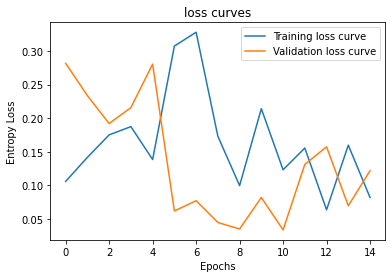

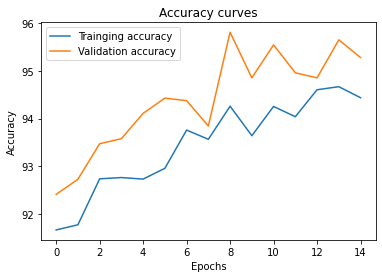

In [0]:
#loss function and optimizer
Epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.015, momentum=0.45)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = resnet18(inputs)               #----> forward pass
        # print(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

In [0]:
test("resnet", "res_bce.csv")

done


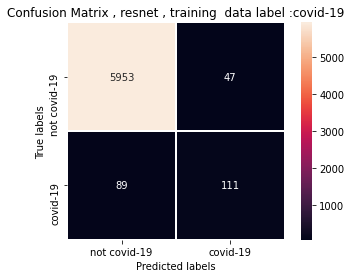

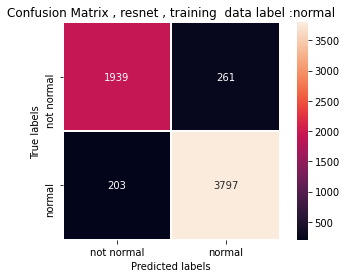

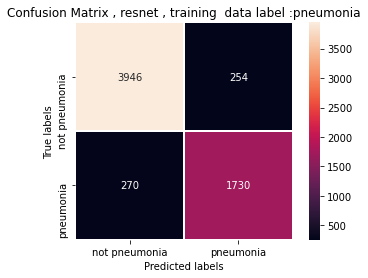

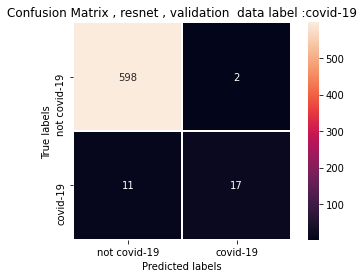

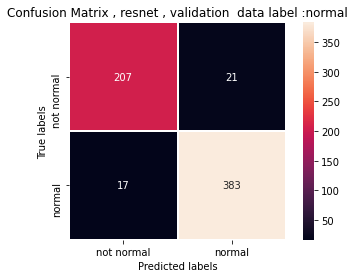

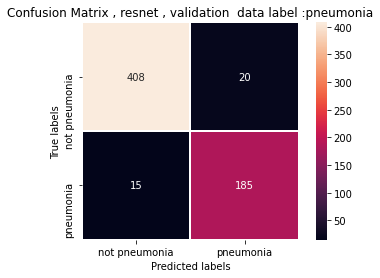

In [7]:
# I am ploting confusion matrix manually, as I have just already got confusion matrix from above code w/o plotting,
#just by using sklearn, and now running again the code is time taking at the last moment so 
#values can be verified from above section results
Training_cm = [[[5953,   47],
  [  89,  111]],

 [[1939  ,261],
  [ 203 ,3797]],

 [[3946  ,254],
  [ 270 ,1730]]]
for i in range(len(classes)):
    plotcm(Training_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'resnet ','training ' )
valid_cm = [[[598,   2],
  [ 11,  17]],

 [[207  ,21],
  [ 17 ,383]],

 [[408  ,20],
  [ 15, 185]]]
for i in range(len(classes)):
    plotcm(valid_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'resnet ','validation ' )

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.116435: : 194it [02:45,  1.17it/s]


Training stats 

confusion matrix [[  32   56  112]
 [ 185 3713  102]
 [ 264  399 1337]]
f1_score 0.5853881489288845
validation stats



0it [00:00, ?it/s]

confusion matrix [[  6  13   9]
 [ 11 379  10]
 [ 14  21 165]]
f1_score 0.6650380513339031

>>tacc, tloss, vacc , vloss
 90.3494623655914 0.5995725989341736 92.19745222929936 0.5895167589187622 
............................



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.234426: : 194it [02:44,  1.18it/s]


Training stats 

confusion matrix [[  26   37  137]
 [ 216 3655  129]
 [ 192  279 1529]]
f1_score 0.601630141191596
validation stats



0it [00:00, ?it/s]

confusion matrix [[  3  11  14]
 [ 12 376  12]
 [ 11  15 174]]
f1_score 0.6395889904867461

>>tacc, tloss, vacc , vloss
 91.8494623655914 0.5995725989341736 93.09978768577494 0.5831853747367859 
............................



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.329419: : 194it [02:44,  1.18it/s]


Training stats 

confusion matrix [[  71   41   88]
 [ 147 3769   84]
 [ 265  338 1397]]
f1_score 0.638631212599846
validation stats



0it [00:00, ?it/s]

confusion matrix [[  9   9  10]
 [ 14 380   6]
 [ 18  23 159]]
f1_score 0.6816100521167988

>>tacc, tloss, vacc , vloss
 91.88709677419355 0.5995725989341736 92.72823779193206 0.6228500604629517 
............................



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.115002: : 194it [02:49,  1.14it/s]


Training stats 

confusion matrix [[  67   26  107]
 [ 248 3628  124]
 [ 173  234 1593]]
f1_score 0.6492682446074698
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 10   8  10]
 [ 24 363  13]
 [  8  13 179]]
f1_score 0.7007606525197142

>>tacc, tloss, vacc , vloss
 92.68817204301077 0.6048488020896912 93.25902335456475 0.5728500485420227 
............................



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.262551: : 194it [02:48,  1.15it/s]


Training stats 

confusion matrix [[  92   17   91]
 [ 233 3553  214]
 [ 143  211 1646]]
f1_score 0.6739687032653731
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 11   9   8]
 [ 19 364  17]
 [  8  13 179]]
f1_score 0.7152268661980702

>>tacc, tloss, vacc , vloss
 92.3978494623656 0.5612424612045288 93.52441613588111 0.5831853747367859 
............................



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.321970: : 194it [02:43,  1.18it/s]


Training stats 

confusion matrix [[  98   15   87]
 [ 189 3676  135]
 [ 135  241 1624]]
f1_score 0.6955015959044623
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 14  11   3]
 [ 18 367  15]
 [ 10  11 179]]
f1_score 0.7440182441398789

>>tacc, tloss, vacc , vloss
 93.3279569892473 0.5717948079109192 93.52441613588111 0.5728501081466675 
............................



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.122202: : 194it [02:46,  1.16it/s]


Training stats 

confusion matrix [[  92   20   88]
 [ 160 3676  164]
 [ 155  238 1607]]
f1_score 0.6875444071555861
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 13  10   5]
 [ 14 373  13]
 [ 11  13 176]]
f1_score 0.7415087796053538

>>tacc, tloss, vacc , vloss
 92.98924731182794 0.6154011487960815 93.63057324840764 0.5601872205734253 
............................



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.045639: : 194it [02:45,  1.17it/s]


Training stats 

confusion matrix [[  99   26   75]
 [ 123 3794   83]
 [ 180  287 1533]]
f1_score 0.6985180335320016
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 16   9   3]
 [  5 384  11]
 [ 11  21 168]]
f1_score 0.7854678095515792

>>tacc, tloss, vacc , vloss
 93.41397849462366 0.6134614944458008 93.78980891719745 0.5831853747367859 
............................



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.255461: : 194it [02:44,  1.18it/s]


Training stats 

confusion matrix [[  93   23   84]
 [ 146 3751  103]
 [ 144  275 1581]]
f1_score 0.6967508909990454
validation stats



0it [00:00, ?it/s]

confusion matrix [[ 13   9   6]
 [  6 386   8]
 [  7  17 176]]
f1_score 0.7782615001005805

>>tacc, tloss, vacc , vloss
 93.3978494623656 0.5995725989341736 94.69214437367303 0.5831853747367859 
............................



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.089230: : 194it [02:46,  1.17it/s]


Training stats 

confusion matrix [[ 106   26   68]
 [ 151 3703  146]
 [ 118  205 1677]]
f1_score 0.721378609513423
validation stats

confusion matrix [[ 16  10   2]
 [ 12 378  10]
 [  3  14 183]]
f1_score 0.8038661837860474

>>tacc, tloss, vacc , vloss
 93.8225806451613 0.5995725989341736 94.53290870488323 0.5791814923286438 
............................

Finished Training


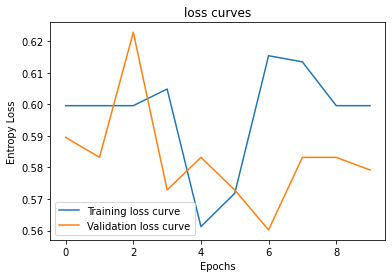

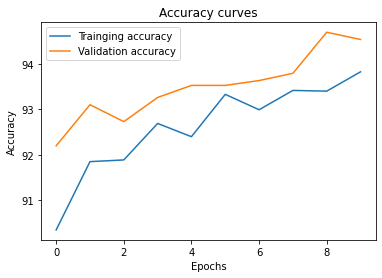

In [0]:
#loss function and optimizer
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.015, momentum=0.45)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = resnet18(inputs)               #----> forward pass
        # print(outputs)
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracy(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracy(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

In [0]:
test("resnet", "res_bce.csv")

done


In [0]:
res_bce=pd.read_csv('res_bce.csv')
res_bce.head()

,0.png,0.0,0.0.1,1.0
0,1.png,0.0,0.0,1.0
1,10.png,0.0,0.0,1.0
2,100.png,0.0,1.0,0.0
3,101.png,0.0,0.0,1.0
4,102.png,0.0,0.0,1.0


## FOCAL LOSS

In [0]:
def focal_los(target,input):
    gamma = 2
    eps = 1e-7
    a = 0.25
    logit = torch.sigmoid(input)
    logit = logit.clamp(eps, 1. - eps)

    loss = -1 * target * torch.log(logit) # ce
    # loss =torch.sum (-a*loss * (1 - logit) ** gamma)
    loss = -a*loss * (1 - logit) ** gamma # focal loss
    return torch.mean(loss)



## resnet with focal loss

In [0]:
resnet18 = models.resnet18(pretrained=True)
new_fc_resnet = [nn.Linear(512, 3) ]
resnet18.fc = nn.Sequential(*new_fc_resnet)
if __name__ == "__main__":
    from torchsummary import summary
    model = resnet18
    model = model.cuda()
    # print(model)
    summary(model, input_size = (3,120,120))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]           9,408
       BatchNorm2d-2           [-1, 64, 60, 60]             128
              ReLU-3           [-1, 64, 60, 60]               0
         MaxPool2d-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,864
       BatchNorm2d-6           [-1, 64, 30, 30]             128
              ReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]          36,864
       BatchNorm2d-9           [-1, 64, 30, 30]             128
             ReLU-10           [-1, 64, 30, 30]               0
       BasicBlock-11           [-1, 64, 30, 30]               0
           Conv2d-12           [-1, 64, 30, 30]          36,864
      BatchNorm2d-13           [-1, 64, 30, 30]             128
             ReLU-14           [-1, 64

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.034083: : 194it [02:54,  1.11it/s]


Training stats 

confusion matrix
  [[  23  105   72]
 [ 221 3518  261]
 [ 160  518 1322]]
confusion_matrix
  [[[5619  381]
  [ 177   23]]

 [[1577  623]
  [ 482 3518]]

 [[3867  333]
  [ 678 1322]]]
f1_score  0.5546062807624265
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  7  18   3]
 [ 21 352  27]
 [ 13  44 143]]
confusion_matrix
  [[[566  34]
  [ 21   7]]

 [[166  62]
  [ 48 352]]

 [[398  30]
  [ 57 143]]]
f1_score  0.611506482587028

>>tacc, tloss, vacc , vloss
 87.20967741935483 0.018926097080111504 86.73036093418258 0.014731770381331444 
............................



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.022053: : 194it [02:44,  1.18it/s]


Training stats 

confusion matrix
  [[  18   78  104]
 [ 142 3604  254]
 [ 127  441 1432]]
confusion_matrix
  [[[5731  269]
  [ 182   18]]

 [[1681  519]
  [ 396 3604]]

 [[3842  358]
  [ 568 1432]]]
f1_score  0.5723172274402936
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  5  16   7]
 [ 15 364  21]
 [ 11  42 147]]
confusion_matrix
  [[[574  26]
  [ 23   5]]

 [[170  58]
  [ 36 364]]

 [[400  28]
  [ 53 147]]]
f1_score  0.6130454314267255

>>tacc, tloss, vacc , vloss
 88.98387096774194 0.017538098618388176 88.26963906581742 0.028710516169667244 
............................



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.011272: : 194it [02:43,  1.19it/s]


Training stats 

confusion matrix
  [[  13   70  117]
 [ 103 3643  254]
 [  70  401 1529]]
confusion_matrix
  [[[5827  173]
  [ 187   13]]

 [[1729  471]
  [ 357 3643]]

 [[3829  371]
  [ 471 1529]]]
f1_score  0.5831380767903965
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  16  10]
 [ 12 365  23]
 [  5  35 160]]
confusion_matrix
  [[[583  17]
  [ 26   2]]

 [[177  51]
  [ 35 365]]

 [[395  33]
  [ 40 160]]]
f1_score  0.5979878633278876

>>tacc, tloss, vacc , vloss
 89.994623655914 0.02346402034163475 89.7027600849257 0.0198297668248415 
............................



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.020803: : 194it [02:43,  1.19it/s]


Training stats 

confusion matrix
  [[  12   48  140]
 [ 114 3584  302]
 [  65  350 1585]]
confusion_matrix
  [[[5821  179]
  [ 188   12]]

 [[1802  398]
  [ 416 3584]]

 [[3758  442]
  [ 415 1585]]]
f1_score  0.5821960371941061
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  13  13]
 [  8 358  34]
 [  8  27 165]]
confusion_matrix
  [[[584  16]
  [ 26   2]]

 [[188  40]
  [ 42 358]]

 [[381  47]
  [ 35 165]]]
f1_score  0.5950568344316539

>>tacc, tloss, vacc , vloss
 90.2258064516129 0.01210769172757864 89.59660297239915 0.024270646274089813 
............................



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.022836: : 194it [02:46,  1.16it/s]


Training stats 

confusion matrix
  [[  23   56  121]
 [ 103 3596  301]
 [  70  339 1591]]
confusion_matrix
  [[[5827  173]
  [ 177   23]]

 [[1805  395]
  [ 404 3596]]

 [[3778  422]
  [ 409 1591]]]
f1_score  0.6030323768297148
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  13  13]
 [ 15 360  25]
 [  9  24 167]]
confusion_matrix
  [[[576  24]
  [ 26   2]]

 [[191  37]
  [ 40 360]]

 [[390  38]
  [ 33 167]]]
f1_score  0.6007177119961171

>>tacc, tloss, vacc , vloss
 90.38709677419355 0.013008254580199718 90.28662420382166 0.028589731082320213 
............................



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.016137: : 194it [02:46,  1.16it/s]


Training stats 

confusion matrix
  [[  29   35  136]
 [  97 3652  251]
 [  59  378 1563]]
confusion_matrix
  [[[5844  156]
  [ 171   29]]

 [[1787  413]
  [ 348 3652]]

 [[3813  387]
  [ 437 1563]]]
f1_score  0.6158944724043173
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  15  11]
 [  8 371  21]
 [  9  31 160]]
confusion_matrix
  [[[583  17]
  [ 26   2]]

 [[182  46]
  [ 29 371]]

 [[396  32]
  [ 40 160]]]
f1_score  0.6032112159950311

>>tacc, tloss, vacc , vloss
 90.94086021505375 0.01576092839241028 90.44585987261146 0.01213952898979187 
............................



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.013748: : 194it [02:48,  1.15it/s]


Training stats 

confusion matrix
  [[  31   34  135]
 [ 114 3516  370]
 [  52  276 1672]]
confusion_matrix
  [[[5834  166]
  [ 169   31]]

 [[1890  310]
  [ 484 3516]]

 [[3695  505]
  [ 328 1672]]]
f1_score  0.6184297256121986
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  12  14]
 [ 10 357  33]
 [  3  23 174]]
confusion_matrix
  [[[587  13]
  [ 26   2]]

 [[193  35]
  [ 43 357]]

 [[381  47]
  [ 26 174]]]
f1_score  0.6070472442482607

>>tacc, tloss, vacc , vloss
 90.505376344086 0.019575731828808784 90.44585987261146 0.012767245061695576 
............................



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.017972: : 194it [02:48,  1.15it/s]


Training stats 

confusion matrix
  [[  35   32  133]
 [  81 3679  240]
 [  55  347 1598]]
confusion_matrix
  [[[5864  136]
  [ 165   35]]

 [[1821  379]
  [ 321 3679]]

 [[3827  373]
  [ 402 1598]]]
f1_score  0.6355480361037106
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  5  12  11]
 [  7 368  25]
 [  7  24 169]]
confusion_matrix
  [[[586  14]
  [ 23   5]]

 [[192  36]
  [ 32 368]]

 [[392  36]
  [ 31 169]]]
f1_score  0.6542522480845053

>>tacc, tloss, vacc , vloss
 91.61290322580645 0.014794073067605495 91.6135881104034 0.0286357831209898 
............................



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.009713: : 194it [02:48,  1.15it/s]


Training stats 

confusion matrix
  [[  42   29  129]
 [  69 3646  285]
 [  44  314 1642]]
confusion_matrix
  [[[5887  113]
  [ 158   42]]

 [[1857  343]
  [ 354 3646]]

 [[3786  414]
  [ 358 1642]]]
f1_score  0.6530131502558106
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  5   8  15]
 [  8 364  28]
 [  4  19 177]]
confusion_matrix
  [[[588  12]
  [ 23   5]]

 [[201  27]
  [ 36 364]]

 [[385  43]
  [ 23 177]]]
f1_score  0.6618111157934167

>>tacc, tloss, vacc , vloss
 91.57526881720432 0.03658463433384895 91.87898089171975 0.011600474826991558 
............................



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.013004: : 194it [02:48,  1.15it/s]


Training stats 

confusion matrix
  [[  50   47  103]
 [  58 3733  209]
 [  52  350 1598]]
confusion_matrix
  [[[5890  110]
  [ 150   50]]

 [[1803  397]
  [ 267 3733]]

 [[3888  312]
  [ 402 1598]]]
f1_score  0.6711654217991456
validation stats

confusion matrix
  [[  5  13  10]
 [  9 370  21]
 [  5  28 167]]
confusion_matrix
  [[[586  14]
  [ 23   5]]

 [[187  41]
  [ 30 370]]

 [[397  31]
  [ 33 167]]]
f1_score  0.6548052327118185

>>tacc, tloss, vacc , vloss
 91.95698924731181 0.010865201242268085 91.66666666666666 0.024743113666772842 
............................

Finished Training


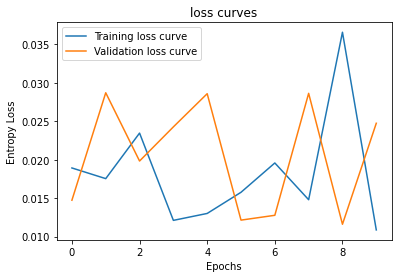

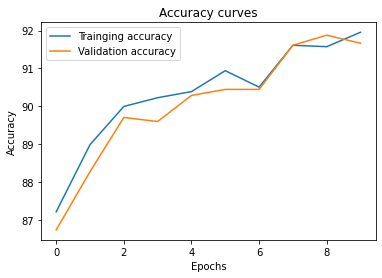

In [0]:
#loss function and optimizer
Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.015, momentum=0.45)
##Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = resnet18(inputs)               #----> forward pass
        # print(outputs)
        loss = focal_loss(labels,outputs)
        # loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(resnet18.state_dict(), 'res18_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracyfocal(trainloader, "resnet")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracyfocal(validloader, "resnet")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")
print('Finished Training')
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)

In [0]:
test("resnet", "res_focallos.csv")

done


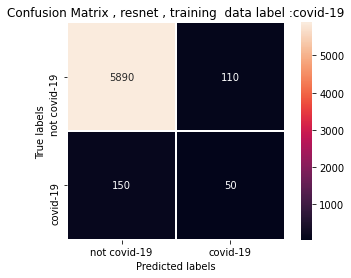

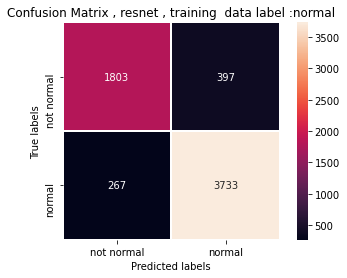

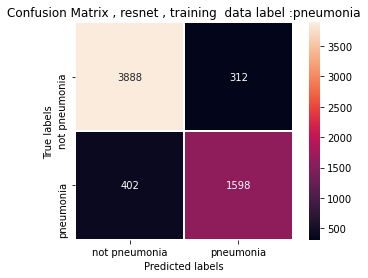

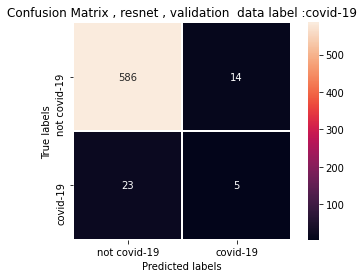

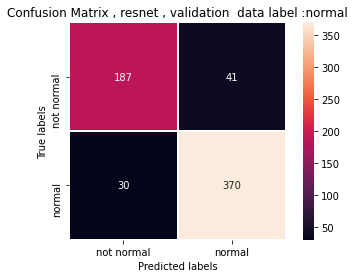

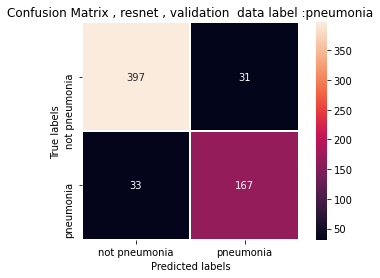

In [8]:
# I am ploting confusion matrix manually, as I have just already got confusion matrix from above code w/o plotting,
#just by using sklearn, and now running again the code is time taking at the last moment so 
#values can be verified from above section results
Training_cm = [[[5890,  110],
  [ 150  , 50]],

 [[1803,  397],
  [ 267, 3733]],

 [[3888,  312],
  [ 402 ,1598]]]
for i in range(len(classes)):
    plotcm(Training_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'resnet ','training ' )
valid_cm = [[[586,  14],
  [ 23 ,  5]],

 [[187  ,41],
  [ 30 ,370]],

 [[397,  31],
  [ 33, 167]]]
for i in range(len(classes)):
    plotcm(valid_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'resnet ','validation ' )

In [0]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6]= nn.Linear(4096, 3)
if __name__ == "__main__":
    from torchsummary import summary
    model = vgg16
    model = model.cuda()
    # print(model)
    summary(model, input_size = (3,120,120))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]           1,792
              ReLU-2         [-1, 64, 120, 120]               0
            Conv2d-3         [-1, 64, 120, 120]          36,928
              ReLU-4         [-1, 64, 120, 120]               0
         MaxPool2d-5           [-1, 64, 60, 60]               0
            Conv2d-6          [-1, 128, 60, 60]          73,856
              ReLU-7          [-1, 128, 60, 60]               0
            Conv2d-8          [-1, 128, 60, 60]         147,584
              ReLU-9          [-1, 128, 60, 60]               0
        MaxPool2d-10          [-1, 128, 30, 30]               0
           Conv2d-11          [-1, 256, 30, 30]         295,168
             ReLU-12          [-1, 256, 30, 30]               0
           Conv2d-13          [-1, 256, 30, 30]         590,080
             ReLU-14          [-1, 256

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.037952: : 194it [04:05,  1.27s/it]


Training stats 

confusion matrix
  [[  33  140   27]
 [ 468 3329  203]
 [ 490 1173  337]]
confusion_matrix
  [[[5042  958]
  [ 167   33]]

 [[ 887 1313]
  [ 671 3329]]

 [[3970  230]
  [1663  337]]]
f1_score  0.3628008112237409
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  5  22   1]
 [ 32 353  15]
 [ 53 103  44]]
confusion_matrix
  [[[515  85]
  [ 23   5]]

 [[103 125]
  [ 47 353]]

 [[412  16]
  [156  44]]]
f1_score  0.40910250965461187

>>tacc, tloss, vacc , vloss
 76.32795698924731 0.03148811310529709 77.28237791932058 0.02879062108695507 
............................



Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.030065: : 194it [03:41,  1.14s/it]


Training stats 

confusion matrix
  [[  34  125   41]
 [ 395 3367  238]
 [ 372  970  658]]
confusion_matrix
  [[[5233  767]
  [ 166   34]]

 [[1105 1095]
  [ 633 3367]]

 [[3921  279]
  [1342  658]]]
f1_score  0.43726709766028976
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  23   3]
 [ 34 356  10]
 [ 48  88  64]]
confusion_matrix
  [[[518  82]
  [ 26   2]]

 [[117 111]
  [ 44 356]]

 [[415  13]
  [136  64]]]
f1_score  0.4396769184066349

>>tacc, tloss, vacc , vloss
 80.18817204301075 0.02915109135210514 80.94479830148619 0.031569767743349075 
............................



Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.025048: : 194it [03:41,  1.14s/it]


Training stats 

confusion matrix
  [[  30  127   43]
 [ 284 3519  197]
 [ 318  879  803]]
confusion_matrix
  [[[5398  602]
  [ 170   30]]

 [[1194 1006]
  [ 481 3519]]

 [[3960  240]
  [1197  803]]]
f1_score  0.4751519604939669
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  1  24   3]
 [ 20 371   9]
 [ 34  85  81]]
confusion_matrix
  [[[546  54]
  [ 27   1]]

 [[119 109]
  [ 29 371]]

 [[416  12]
  [119  81]]]
f1_score  0.4733930758715907

>>tacc, tloss, vacc , vloss
 82.84408602150538 0.023208826780319214 83.33333333333334 0.023453297093510628 
............................



Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.016245: : 194it [03:40,  1.13s/it]


Training stats 

confusion matrix
  [[  22  121   57]
 [ 260 3480  260]
 [ 266  749  985]]
confusion_matrix
  [[[5474  526]
  [ 178   22]]

 [[1330  870]
  [ 520 3480]]

 [[3883  317]
  [1015  985]]]
f1_score  0.496321526612219
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  23   3]
 [ 25 360  15]
 [ 20  58 122]]
confusion_matrix
  [[[555  45]
  [ 26   2]]

 [[147  81]
  [ 40 360]]

 [[410  18]
  [ 78 122]]]
f1_score  0.5423680181545468

>>tacc, tloss, vacc , vloss
 83.94086021505376 0.021192822605371475 85.35031847133757 0.019191695377230644 
............................



Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.022450: : 194it [03:39,  1.13s/it]


Training stats 

confusion matrix
  [[  23  107   70]
 [ 233 3489  278]
 [ 215  704 1081]]
confusion_matrix
  [[[5552  448]
  [ 177   23]]

 [[1389  811]
  [ 511 3489]]

 [[3852  348]
  [ 919 1081]]]
f1_score  0.5132606027526047
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  20   6]
 [ 22 357  21]
 [ 15  66 119]]
confusion_matrix
  [[[563  37]
  [ 26   2]]

 [[142  86]
  [ 43 357]]

 [[401  27]
  [ 81 119]]]
f1_score  0.5315126177271952

>>tacc, tloss, vacc , vloss
 84.8279569892473 0.025879884138703346 84.60721868365181 0.03216797485947609 
............................



Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.026267: : 194it [03:40,  1.13s/it]


Training stats 

confusion matrix
  [[  16   97   87]
 [ 207 3492  301]
 [ 165  631 1204]]
confusion_matrix
  [[[5628  372]
  [ 184   16]]

 [[1472  728]
  [ 508 3492]]

 [[3812  388]
  [ 796 1204]]]
f1_score  0.5248118081191694
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  5  18   5]
 [ 16 364  20]
 [ 16  59 125]]
confusion_matrix
  [[[568  32]
  [ 23   5]]

 [[151  77]
  [ 36 364]]

 [[403  25]
  [ 75 125]]]
f1_score  0.5779226718584626

>>tacc, tloss, vacc , vloss
 85.71505376344085 0.020538361743092537 86.57112526539278 0.024756718426942825 
............................



Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.019135: : 194it [03:40,  1.14s/it]


Training stats 

confusion matrix
  [[  16  103   81]
 [ 216 3475  309]
 [ 126  590 1284]]
confusion_matrix
  [[[5658  342]
  [ 184   16]]

 [[1507  693]
  [ 525 3475]]

 [[3810  390]
  [ 716 1284]]]
f1_score  0.5357316213137193
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  2  20   6]
 [ 19 366  15]
 [ 17  58 125]]
confusion_matrix
  [[[564  36]
  [ 26   2]]

 [[150  78]
  [ 34 366]]

 [[407  21]
  [ 75 125]]]
f1_score  0.5501493304687562

>>tacc, tloss, vacc , vloss
 86.13978494623657 0.024276135489344597 86.57112526539278 0.02090677060186863 
............................



Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.033360: : 194it [03:40,  1.14s/it]


Training stats 

confusion matrix
  [[  21   83   96]
 [ 201 3461  338]
 [ 146  536 1318]]
confusion_matrix
  [[[5653  347]
  [ 179   21]]

 [[1581  619]
  [ 539 3461]]

 [[3766  434]
  [ 682 1318]]]
f1_score  0.5443951552277063
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  3  18   7]
 [ 14 367  19]
 [ 12  53 135]]
confusion_matrix
  [[[574  26]
  [ 25   3]]

 [[157  71]
  [ 33 367]]

 [[402  26]
  [ 65 135]]]
f1_score  0.5763601945448976

>>tacc, tloss, vacc , vloss
 86.41397849462366 0.024045675992965698 87.47346072186836 0.012046879157423973 
............................



Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.026166: : 194it [03:42,  1.15s/it]


Training stats 

confusion matrix
  [[  20   83   97]
 [ 170 3540  290]
 [ 120  556 1324]]
confusion_matrix
  [[[5710  290]
  [ 180   20]]

 [[1561  639]
  [ 460 3540]]

 [[3813  387]
  [ 676 1324]]]
f1_score  0.5525390552915727
validation stats



0it [00:00, ?it/s]

confusion matrix
  [[  3  18   7]
 [ 10 374  16]
 [  9  52 139]]
confusion_matrix
  [[[581  19]
  [ 25   3]]

 [[158  70]
  [ 26 374]]

 [[405  23]
  [ 61 139]]]
f1_score  0.5914039084251961

>>tacc, tloss, vacc , vloss
 87.19892473118279 0.022634802386164665 88.00424628450106 0.011629634536802769 
............................



Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.023309: : 194it [03:40,  1.14s/it]


Training stats 

confusion matrix
  [[  18   84   98]
 [ 179 3512  309]
 [ 110  486 1404]]
confusion_matrix
  [[[5711  289]
  [ 182   18]]

 [[1630  570]
  [ 488 3512]]

 [[3793  407]
  [ 596 1404]]]
f1_score  0.5589707368350806
validation stats

confusion matrix
  [[  2  17   9]
 [ 13 366  21]
 [ 15  51 134]]
confusion_matrix
  [[[572  28]
  [ 26   2]]

 [[160  68]
  [ 34 366]]

 [[398  30]
  [ 66 134]]]
f1_score  0.5609756984105781

>>tacc, tloss, vacc , vloss
 87.54838709677419 0.015144146047532558 87.68577494692144 0.012434192933142185 
............................

Finished Training


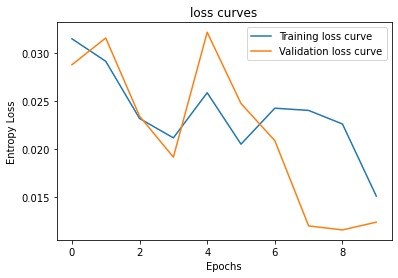

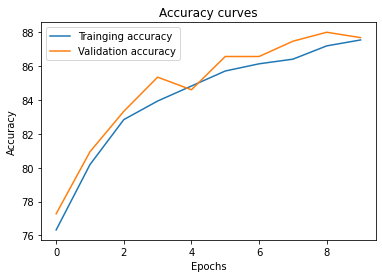

done


In [0]:
#loss function and optimizer
Epochs = 10
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.5)
#Training
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
trainAccuracy =[]
validAccuracy = []
TrainLoss =[]
ValidLoss=[]
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # print(labels)
        labels = Encode(labels)
        outputs = vgg16(inputs)               #----> forward pass
        # print(outputs)
        loss = focal_loss(labels,outputs)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')
    print("Training stats \n")
    tacc, tloss = getAccuracyfocal(trainloader, "vgg")
    trainAccuracy.append(tacc)
    TrainLoss.append(tloss)
    # print(tacc, tloss)
    print("validation stats\n")
    vacc , vloss = getAccuracyfocal(validloader, "vgg")
    validAccuracy.append(vacc)
    ValidLoss.append(vloss)
    print("\n>>tacc, tloss, vacc , vloss\n",tacc, tloss, vacc , vloss ,"\n............................\n")

print('Finished Training')
plot(trainAccuracy,TrainLoss, validAccuracy, ValidLoss)
# test("vgg", "vgg_bce.csv")

In [0]:
test("vgg", "vgg_focallos.csv")

done


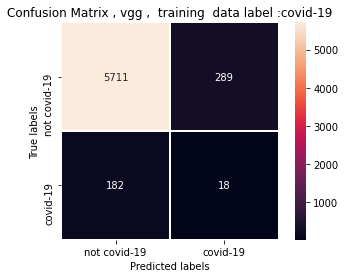

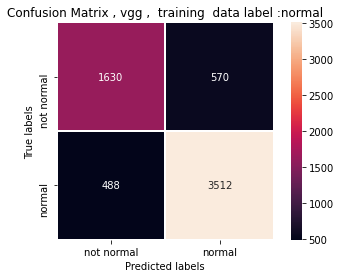

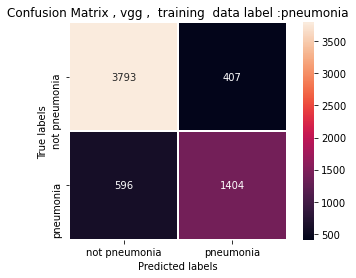

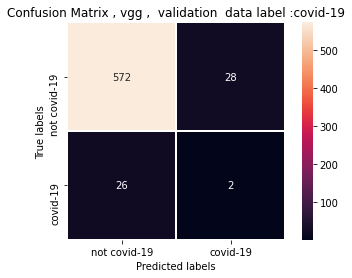

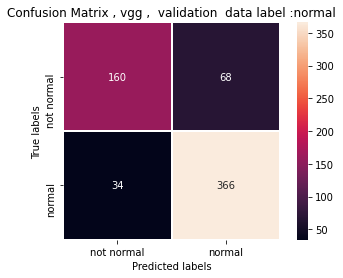

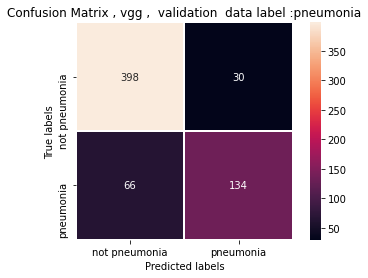

In [9]:
# I am ploting confusion matrix manually, as I have just already got confusion matrix from above code w/o plotting,
#just by using sklearn, and now running again the code is time taking at the last moment so 
#values can be verified from above section results
Training_cm = [[[5711 , 289],
  [ 182 ,  18]],

 [[1630,  570],
  [ 488, 3512]],

 [[3793 , 407],
  [ 596 ,1404]]]
for i in range(len(classes)):
    plotcm(Training_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'vgg ',' training ' )
valid_cm = [[[572,  28],
  [ 26,   2]],

 [[160 , 68],
  [ 34, 366]],

 [[398 , 30],
  [ 66 ,134]]]
for i in range(len(classes)):
    plotcm(valid_cm[i], classes[i], ['not ' + classes[i],classes[i]], 'vgg ',' validation ' )